In [17]:
import sqlite3
import datetime
from dateutil.relativedelta import relativedelta
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate


In [19]:
import sqlite3
import datetime
from dateutil.relativedelta import relativedelta
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate

class LoanApplication:
    def __init__(self, db_name='loan_data.db'):
        self.conn = sqlite3.connect(db_name)
        self.create_tables()

    def create_tables(self):
        with self.conn:
            self.conn.execute('''
                CREATE TABLE IF NOT EXISTS loans (
                    id INTEGER PRIMARY KEY,
                    property_value REAL,
                    down_payment REAL,
                    principal REAL,
                    annual_interest_rate REAL,
                    loan_term_years INTEGER,
                    annual_property_tax_rate REAL,
                    annual_insurance REAL,
                    start_date TEXT,
                    monthly_payment REAL,
                    total_monthly_payment REAL
                )
            ''')
            self.conn.execute('''
                CREATE TABLE IF NOT EXISTS payments (
                    id INTEGER PRIMARY KEY,
                    loan_id INTEGER,
                    payment_date TEXT,
                    amount REAL,
                    principal_paid REAL,
                    interest_paid REAL,
                    balance_after_payment REAL,
                    FOREIGN KEY (loan_id) REFERENCES loans (id)
                )
            ''')

    def create_loan(self, property_value, down_payment, annual_interest_rate, loan_term_years, annual_property_tax_rate, annual_insurance):
        principal = property_value - down_payment
        monthly_interest_rate = annual_interest_rate / 12 / 100
        total_payments = loan_term_years * 12
        
        monthly_payment = principal * (monthly_interest_rate * (1 + monthly_interest_rate) ** total_payments) / ((1 + monthly_interest_rate) ** total_payments - 1)
        monthly_property_tax = (property_value * annual_property_tax_rate / 100) / 12
        monthly_insurance = annual_insurance / 12
        total_monthly_payment = monthly_payment + monthly_property_tax + monthly_insurance
        
        start_date = datetime.date.today().isoformat()

        with self.conn:
            cursor = self.conn.execute('''
                INSERT INTO loans (property_value, down_payment, principal, annual_interest_rate, loan_term_years, 
                                   annual_property_tax_rate, annual_insurance, start_date, monthly_payment, total_monthly_payment)
                VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
            ''', (property_value, down_payment, principal, annual_interest_rate, loan_term_years, 
                  annual_property_tax_rate, annual_insurance, start_date, monthly_payment, total_monthly_payment))
            
        return cursor.lastrowid

    def input_payment(self, loan_id):
        loan = self.get_loan(loan_id)
        if not loan:
            print("Loan not found.")
            return

        while True:
            try:
                payment_date = input("Enter payment date (YYYY-MM-DD): ")
                datetime.date.fromisoformat(payment_date)  # Validate date format
                amount = float(input("Enter payment amount: $"))
                break
            except ValueError:
                print("Invalid input. Please try again.")

        if self.make_payment(loan_id, payment_date, amount):
            print("Payment recorded successfully.")
        else:
            print("Failed to record payment.")

    def delete_payment(self, loan_id):
        payments = self.get_payment_history(loan_id)
        if not payments:
            print("No payments found for this loan.")
            return

        print("\nPayment History:")
        print(self.display_payment_history(loan_id))

        while True:
            try:
                payment_id = int(input("Enter the ID of the payment to delete: "))
                if payment_id not in [payment['id'] for payment in payments]:
                    print("Invalid payment ID. Please try again.")
                    continue
                break
            except ValueError:
                print("Invalid input. Please enter a number.")

        with self.conn:
            self.conn.execute('DELETE FROM payments WHERE id = ?', (payment_id,))
        print("Payment deleted successfully.")
        self.recalculate_balances(loan_id, payment_id)

    def recalculate_balances(self, loan_id, deleted_payment_id):
        loan = self.get_loan(loan_id)
        payments = self.get_payment_history(loan_id)
        
        previous_payment = next((p for p in reversed(payments) if p['id'] < deleted_payment_id), None)
        
        if previous_payment:
            current_balance = previous_payment['balance_after_payment']
        else:
            current_balance = loan['principal']

        monthly_interest_rate = loan['annual_interest_rate'] / 12 / 100

        for payment in (p for p in payments if p['id'] > deleted_payment_id):
            interest_due = current_balance * monthly_interest_rate
            principal_paid = payment['amount'] - interest_due
            current_balance -= principal_paid

            with self.conn:
                self.conn.execute('''
                    UPDATE payments
                    SET principal_paid = ?, interest_paid = ?, balance_after_payment = ?
                    WHERE id = ?
                ''', (principal_paid, interest_due, current_balance, payment['id']))

    def make_payment(self, loan_id, payment_date, amount):
        loan = self.get_loan(loan_id)
        if not loan:
            return False

        balance = self.get_current_balance(loan_id)
        monthly_interest_rate = loan['annual_interest_rate'] / 12 / 100
        interest_due = balance * monthly_interest_rate
        principal_paid = min(amount, balance) - interest_due if amount > interest_due else 0
        interest_paid = min(amount, interest_due)
        new_balance = balance - principal_paid

        with self.conn:
            self.conn.execute('''
                INSERT INTO payments (loan_id, payment_date, amount, principal_paid, interest_paid, balance_after_payment)
                VALUES (?, ?, ?, ?, ?, ?)
            ''', (loan_id, payment_date, amount, principal_paid, interest_paid, new_balance))

        return True

    def get_loan(self, loan_id):
        cursor = self.conn.execute('SELECT * FROM loans WHERE id = ?', (loan_id,))
        columns = [column[0] for column in cursor.description]
        result = cursor.fetchone()
        return dict(zip(columns, result)) if result else None

    def get_current_balance(self, loan_id):
        cursor = self.conn.execute('''
            SELECT balance_after_payment 
            FROM payments 
            WHERE loan_id = ? 
            ORDER BY payment_date DESC 
            LIMIT 1
        ''', (loan_id,))
        result = cursor.fetchone()
        if result:
            return result[0]
        else:
            loan = self.get_loan(loan_id)
            return loan['principal'] if loan else None

    def get_payment_history(self, loan_id):
        cursor = self.conn.execute('SELECT * FROM payments WHERE loan_id = ? ORDER BY payment_date', (loan_id,))
        columns = [column[0] for column in cursor.description]
        return [dict(zip(columns, row)) for row in cursor.fetchall()]

    def generate_amortization_schedule(self, loan_id):
        loan = self.get_loan(loan_id)
        if not loan:
            return None

        schedule = []
        balance = loan['principal']
        payment_number = 1
        payment_date = datetime.date.fromisoformat(loan['start_date'])
        monthly_interest_rate = loan['annual_interest_rate'] / 12 / 100

        while balance > 0 and payment_number <= loan['loan_term_years'] * 12:
            interest_payment = balance * monthly_interest_rate
            principal_payment = loan['monthly_payment'] - interest_payment
            balance = max(balance - principal_payment, 0)

            schedule.append({
                'Payment Number': payment_number,
                'Payment Date': payment_date,
                'Payment Amount': loan['monthly_payment'],
                'Principal Paid': principal_payment,
                'Interest Paid': interest_payment,
                'Remaining Balance': balance
            })

            payment_number += 1
            payment_date += relativedelta(months=1)

        return pd.DataFrame(schedule)

    def plot_amortization_schedule(self, loan_id):
        schedule = self.generate_amortization_schedule(loan_id)
        if schedule is None:
            print("Unable to generate amortization schedule.")
            return

        plt.figure(figsize=(12, 6))
        plt.plot(schedule['Payment Number'], schedule['Principal Paid'], label='Principal')
        plt.plot(schedule['Payment Number'], schedule['Interest Paid'], label='Interest')
        plt.title('Amortization Schedule')
        plt.xlabel('Payment Number')
        plt.ylabel('Amount')
        plt.legend()
        plt.grid(True)
        plt.show()

    def generate_loan_summary(self, loan_id):
        loan = self.get_loan(loan_id)
        if not loan:
            return "Loan not found."

        current_balance = self.get_current_balance(loan_id)
        payments = self.get_payment_history(loan_id)
        total_paid = sum(payment['amount'] for payment in payments)
        total_interest_paid = sum(payment['interest_paid'] for payment in payments)

        summary = f"Loan Summary for Loan ID: {loan_id}\n"
        summary += f"Original Principal: ${loan['principal']:,.2f}\n"
        summary += f"Current Balance: ${current_balance:,.2f}\n"
        summary += f"Total Paid to Date: ${total_paid:,.2f}\n"
        summary += f"Total Interest Paid: ${total_interest_paid:,.2f}\n"
        summary += f"Monthly Payment: ${loan['monthly_payment']:,.2f}\n"
        summary += f"Total Monthly Payment (including taxes and insurance): ${loan['total_monthly_payment']:,.2f}\n"
        summary += f"Loan Term: {loan['loan_term_years']} years\n"
        summary += f"Start Date: {loan['start_date']}\n"
        summary += f"Annual Interest Rate: {loan['annual_interest_rate']}%\n"

        return summary

    def display_payment_history(self, loan_id):
        payments = self.get_payment_history(loan_id)
        if not payments:
            return "No payment history available for this loan."

        table_data = [[
            payment['id'],
            payment['payment_date'],
            f"${payment['amount']:.2f}",
            f"${payment['principal_paid']:.2f}",
            f"${payment['interest_paid']:.2f}",
            f"${payment['balance_after_payment']:.2f}"
        ] for payment in payments]

        headers = ["Payment ID", "Payment Date", "Amount Paid", "Principal Paid", "Interest Paid", "Remaining Balance"]

        table = tabulate(table_data, headers=headers, tablefmt="grid")
        return table


Loan Management Menu:
1. Make a payment
2. View loan summary
3. View payment history
4. Delete a payment
5. View amortization schedule
6. Exit


Enter your choice (1-6):  3


No payment history available for this loan.

Loan Management Menu:
1. Make a payment
2. View loan summary
3. View payment history
4. Delete a payment
5. View amortization schedule
6. Exit


Enter your choice (1-6):  4


No payments found for this loan.

Loan Management Menu:
1. Make a payment
2. View loan summary
3. View payment history
4. Delete a payment
5. View amortization schedule
6. Exit


Enter your choice (1-6):  1
Enter payment date (YYYY-MM-DD):  2024-08-12
Enter payment amount: $ 1910.07


Payment recorded successfully.

Loan Management Menu:
1. Make a payment
2. View loan summary
3. View payment history
4. Delete a payment
5. View amortization schedule
6. Exit


Enter your choice (1-6):  1
Enter payment date (YYYY-MM-DD):  2024-09-12
Enter payment amount: $ 3


Payment recorded successfully.

Loan Management Menu:
1. Make a payment
2. View loan summary
3. View payment history
4. Delete a payment
5. View amortization schedule
6. Exit


Enter your choice (1-6):  3


+--------------+----------------+---------------+------------------+-----------------+---------------------+
|   Payment ID | Payment Date   | Amount Paid   | Principal Paid   | Interest Paid   | Remaining Balance   |
+==============+================+===============+==================+=================+=====================+
|           11 | 2024-08-12     | $1910.07      | $910.07          | $1000.00        | $199089.93          |
+--------------+----------------+---------------+------------------+-----------------+---------------------+
|           12 | 2024-09-12     | $3.00         | $0.00            | $3.00           | $199089.93          |
+--------------+----------------+---------------+------------------+-----------------+---------------------+

Loan Management Menu:
1. Make a payment
2. View loan summary
3. View payment history
4. Delete a payment
5. View amortization schedule
6. Exit


Enter your choice (1-6):  4



Payment History:
+--------------+----------------+---------------+------------------+-----------------+---------------------+
|   Payment ID | Payment Date   | Amount Paid   | Principal Paid   | Interest Paid   | Remaining Balance   |
+==============+================+===============+==================+=================+=====================+
|           11 | 2024-08-12     | $1910.07      | $910.07          | $1000.00        | $199089.93          |
+--------------+----------------+---------------+------------------+-----------------+---------------------+
|           12 | 2024-09-12     | $3.00         | $0.00            | $3.00           | $199089.93          |
+--------------+----------------+---------------+------------------+-----------------+---------------------+


Enter the ID of the payment to delete:  12


Payment deleted successfully.

Loan Management Menu:
1. Make a payment
2. View loan summary
3. View payment history
4. Delete a payment
5. View amortization schedule
6. Exit


Enter your choice (1-6):  3


+--------------+----------------+---------------+------------------+-----------------+---------------------+
|   Payment ID | Payment Date   | Amount Paid   | Principal Paid   | Interest Paid   | Remaining Balance   |
+==============+================+===============+==================+=================+=====================+
|           11 | 2024-08-12     | $1910.07      | $910.07          | $1000.00        | $199089.93          |
+--------------+----------------+---------------+------------------+-----------------+---------------------+

Loan Management Menu:
1. Make a payment
2. View loan summary
3. View payment history
4. Delete a payment
5. View amortization schedule
6. Exit


Enter your choice (1-6):  1
Enter payment date (YYYY-MM-DD):  2024-09-12
Enter payment amount: $ 1910.07


Payment recorded successfully.

Loan Management Menu:
1. Make a payment
2. View loan summary
3. View payment history
4. Delete a payment
5. View amortization schedule
6. Exit


Enter your choice (1-6):  3


+--------------+----------------+---------------+------------------+-----------------+---------------------+
|   Payment ID | Payment Date   | Amount Paid   | Principal Paid   | Interest Paid   | Remaining Balance   |
+==============+================+===============+==================+=================+=====================+
|           11 | 2024-08-12     | $1910.07      | $910.07          | $1000.00        | $199089.93          |
+--------------+----------------+---------------+------------------+-----------------+---------------------+
|           12 | 2024-09-12     | $1910.07      | $914.62          | $995.45         | $198175.31          |
+--------------+----------------+---------------+------------------+-----------------+---------------------+

Loan Management Menu:
1. Make a payment
2. View loan summary
3. View payment history
4. Delete a payment
5. View amortization schedule
6. Exit


Enter your choice (1-6):  2


Loan Summary for Loan ID: 9
Original Principal: $200,000.00
Current Balance: $198,175.31
Total Paid to Date: $3,820.14
Total Interest Paid: $1,995.45
Monthly Payment: $1,687.71
Total Monthly Payment (including taxes and insurance): $1,910.07
Loan Term: 15 years
Start Date: 2024-08-12
Annual Interest Rate: 6.0%


Loan Management Menu:
1. Make a payment
2. View loan summary
3. View payment history
4. Delete a payment
5. View amortization schedule
6. Exit


Enter your choice (1-6):  5


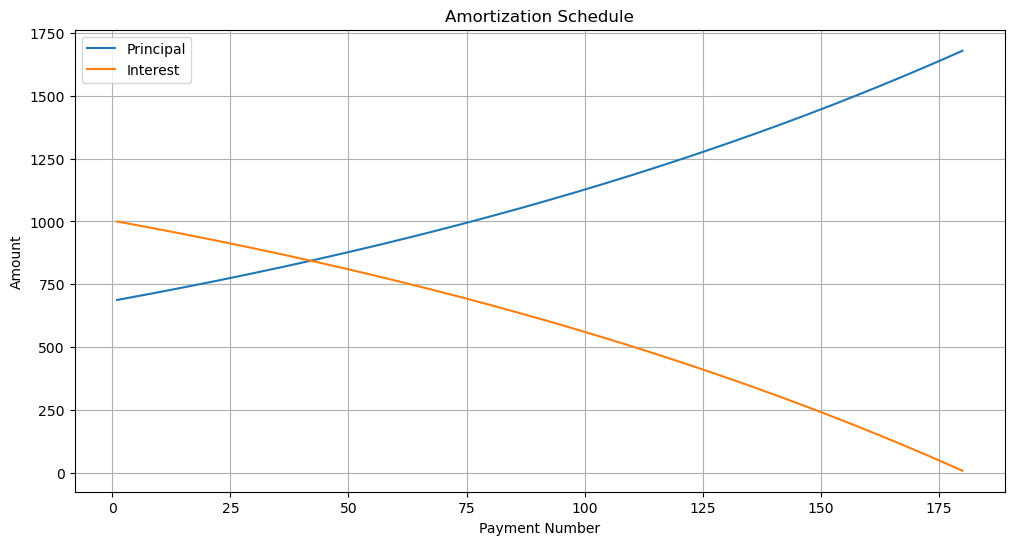


Loan Management Menu:
1. Make a payment
2. View loan summary
3. View payment history
4. Delete a payment
5. View amortization schedule
6. Exit


Enter your choice (1-6):  6


Exiting the program.


In [21]:
# Example usage:
if __name__ == "__main__":
    app = LoanApplication()

    # Create a new loan
    loan_id = app.create_loan(
        property_value=275000,
        down_payment=75000,
        annual_interest_rate=6,
        loan_term_years=15,
        annual_property_tax_rate=0.5339,
        annual_insurance=1200
    )

    while True:
        print("\nLoan Management Menu:")
        print("1. Make a payment")
        print("2. View loan summary")
        print("3. View payment history")
        print("4. Delete a payment")
        print("5. View amortization schedule")
        print("6. Exit")
        
        choice = input("Enter your choice (1-6): ")
        
        if choice == '1':
            app.input_payment(loan_id)
        elif choice == '2':
            print(app.generate_loan_summary(loan_id))
        elif choice == '3':
            print(app.display_payment_history(loan_id))
        elif choice == '4':
            app.delete_payment(loan_id)
        elif choice == '5':
            app.plot_amortization_schedule(loan_id)
        elif choice == '6':
            print("Exiting the program.")
            break
        else:
            print("Invalid choice. Please try again.")